In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=train_transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=test_transform
)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=8)

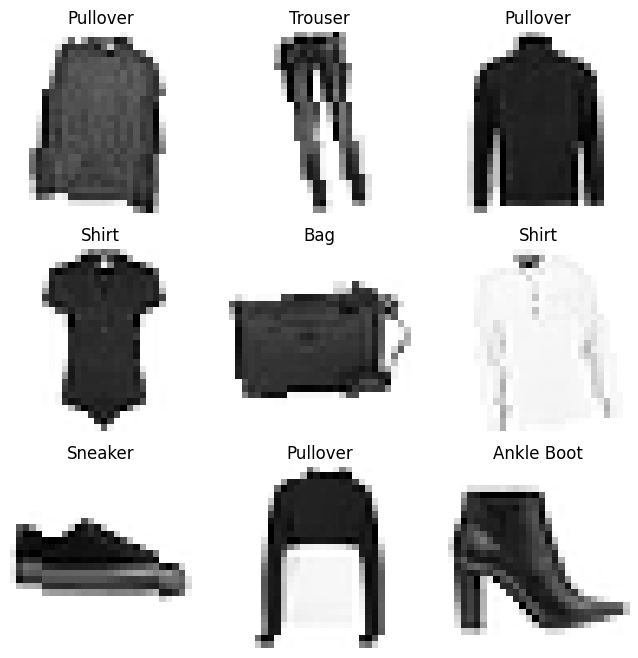

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="Grays")
plt.show()

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.Conv2d(6, 16, 5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*4*4, 120),
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.BatchNorm1d(84),
            nn.Linear(84, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [5]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(1, 8, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 16, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Flatten(),
            nn.Linear(16*7*7, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.Softmax(1)
        )

    def forward(self, x):
        logits = self.conv_stack(x)
        return logits

In [6]:
class NetworkTrainer:
    def __init__(self, model: nn.Module, 
                 loss_fn: nn.modules.loss._Loss, 
                 optimiser: optim.Optimizer,
                 scheduler: optim.lr_scheduler._LRScheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimiser = optimiser
        self.scheduler = scheduler

    def train_model(self, epochs):
        train_loss_list = []
        train_acc_list = []
        test_loss_list = []
        test_acc_list = []
        for epoch in range(epochs):
            print(f'EPOCH {epoch+1}')
            train_loss, train_acc = self._train_epoch()
            test_loss, test_acc = self._eval_epoch()
            self.scheduler.step()
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            test_loss_list.append(test_loss)
            test_acc_list.append(test_acc)
            print(f'Loss: {train_loss:.3f}, Val_Loss: {test_loss:.3f}')
            print(f'Accuracy: {train_acc:.2f}, Val_Accuracy: {test_acc:.2f}\n')
        return train_loss_list, train_acc_list, test_loss_list, test_acc_list

    def _train_epoch(self):
        self.model.train(True)
        running_loss = 0.0
        correct = 0
        for i, data in enumerate(train_dataloader):
            inputs: torch.Tensor = data[0]
            labels = data[1]
            self.optimiser.zero_grad()
            outputs = self.model(inputs)
            loss: torch.Tensor = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimiser.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(train_data)
        accuracy = 100 * correct / len(train_data)
        return avg_loss, accuracy

    def _eval_epoch(self):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader):
                inputs: torch.Tensor = data[0]
                labels = data[1]
                outputs = self.model(inputs)
                loss = self.loss_fn(outputs, labels)
                running_loss += loss * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += torch.sum(preds == labels)
        avg_loss = running_loss / len(test_data)
        accuracy = 100 * correct / len(test_data)
        return avg_loss, accuracy

In [11]:
def plot_results(results):
    train_loss_list, train_acc_list, test_loss_list, test_acc_list = results

    epochs = len(train_loss_list)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8, 4.8))
    ax1.plot(range(1,epochs+1), train_loss_list, label='Train')
    ax1.plot(range(1,epochs+1), test_loss_list, label='Test')
    ax1.set_xticks(range(5,epochs+1,5))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax2.plot(range(1,epochs+1), train_acc_list, label='Train')
    ax2.plot(range(1,epochs+1), test_acc_list, label='Test')
    ax2.set_xticks(range(5,epochs+1,5))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [9]:
loss_fn = nn.CrossEntropyLoss()
model = VGG().to(device)
optimiser = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimiser, 10)

EPOCH 1
Loss: 1.654, Val_Loss: 1.621
Accuracy: 80.97, Val_Accuracy: 84.18

EPOCH 2
Loss: 1.608, Val_Loss: 1.596
Accuracy: 85.38, Val_Accuracy: 86.49

EPOCH 3
Loss: 1.594, Val_Loss: 1.595
Accuracy: 86.69, Val_Accuracy: 86.53

EPOCH 4
Loss: 1.586, Val_Loss: 1.580
Accuracy: 87.50, Val_Accuracy: 88.13

EPOCH 5
Loss: 1.582, Val_Loss: 1.595
Accuracy: 88.01, Val_Accuracy: 86.69

EPOCH 6
Loss: 1.578, Val_Loss: 1.582
Accuracy: 88.38, Val_Accuracy: 88.05

EPOCH 7
Loss: 1.574, Val_Loss: 1.569
Accuracy: 88.82, Val_Accuracy: 89.28

EPOCH 8
Loss: 1.570, Val_Loss: 1.571
Accuracy: 89.14, Val_Accuracy: 89.04

EPOCH 9
Loss: 1.571, Val_Loss: 1.576
Accuracy: 89.15, Val_Accuracy: 88.64

EPOCH 10
Loss: 1.567, Val_Loss: 1.571
Accuracy: 89.54, Val_Accuracy: 89.08

EPOCH 11
Loss: 1.554, Val_Loss: 1.551
Accuracy: 90.79, Val_Accuracy: 91.02

EPOCH 12
Loss: 1.549, Val_Loss: 1.548
Accuracy: 91.31, Val_Accuracy: 91.36

EPOCH 13
Loss: 1.546, Val_Loss: 1.548
Accuracy: 91.58, Val_Accuracy: 91.40

EPOCH 14
Loss: 1.545,

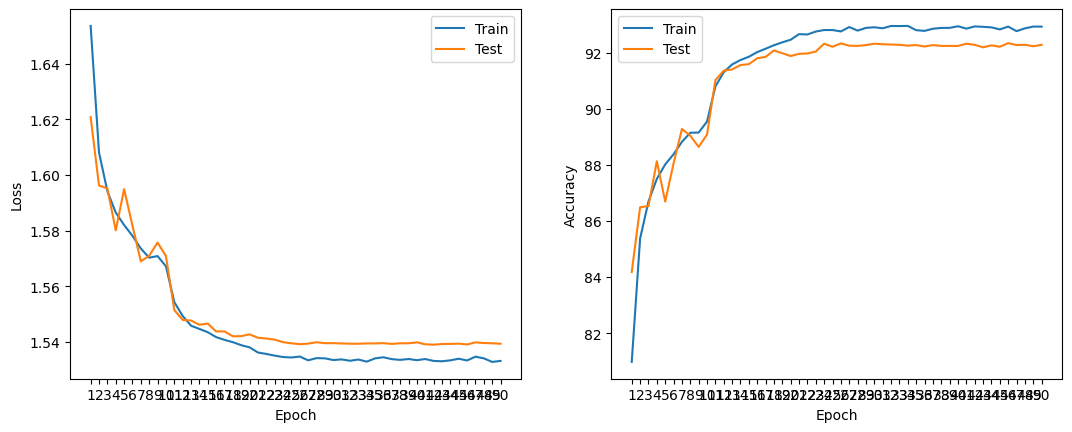

In [10]:
trainer = NetworkTrainer(model, loss_fn, optimiser, scheduler)
results = trainer.train_model(50)
plot_results(results)

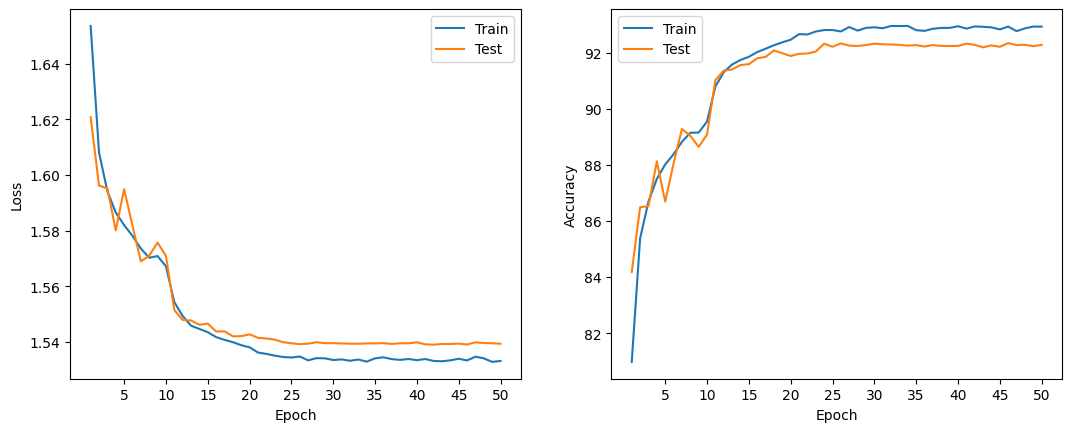

In [12]:
plot_results(results)

In [31]:
model.eval()
y_test = []
y_pred = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        inputs: torch.Tensor = data[0]
        labels = data[1]
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_test.extend(labels)
        y_pred.extend(preds)

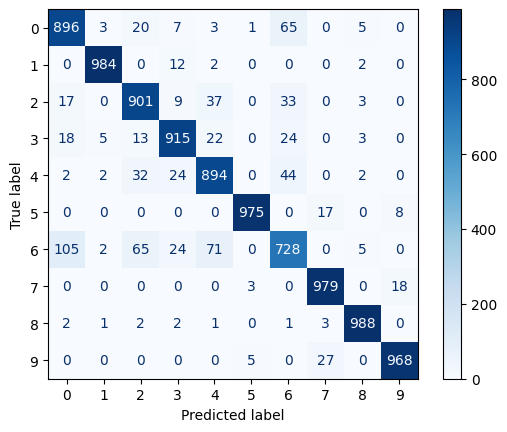

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')